$$
\newcommand{\Oframe}{\mathcal{O}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\Uset}{\mathcal{U}}
\newcommand{\braces}[1]{\left\{#1\right\}}
\newcommand{\Rbot}{\mathcal{R}}
\newcommand{\Workspace}{\mathcal{W}}
$$

In [1]:
# IMPORT mypy LIBRARY ALLOWING TYPE ANNOTATION AND INFERENCE
from typing import List, Tuple, Set, Dict, Callable, Iterable, Any, NamedTuple
import itertools
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
%matplotlib inline

# Preliminaries
Consider a point robot, $\Rbot$ moving in a 2D workspace.  Let $\Oframe$ denote the 2D cartesian coordinate frame, which will also be called the *world coordinate frame*.  The configuration, $q$, of the point is the pair of numbers representing the coordinates of the point in frame $\Oframe$
$$
\begin{equation}
q = (x, y) \,\, \in \,\, \R^2
\end{equation}
$$

In [2]:

class Configuration:
    """
    A configuration of robot $\Rbot$.
    """
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y = y
        
    def __add__(self, other: 'Configuration') -> 'Configuration':
        x = self.x + other.x
        y = self.y + other.y
        return Configuration(x, y)
    
    def __repr__(self) -> None:
        fmtstr = "Configuration({:f}, {:f})"
        return fmtstr.format(self.x, self.y)
    
    def __str__(self):
        fmtstr = "({:.2f}, {:.2f})"
        return fmtstr.format(self.x, self.y)



The configuration of the robot at time $t$ is denoted $q(t)$, i.e. the configuration is a *function of time*.  When we consider the *motion* of $\Rbot$, we mean the evolution of its configuration over time.  If we consider continuous evolution in time, the term motion can refer to differential changes in position with respect to time, i.e. velocities.  As our models get more realistic, motion can refer to higher derivatives such as acceleration and jerk.  

Let us at first restrict the idea of motion to the velocity of $\Rbot$.  The velocity is denoted by
$$
\begin{equation}
\dot{q}(t) = (\dot{q}_1(t), \dot{q}_2(t))
\end{equation}
$$



In [3]:
class Velocity:
    """
    A data structure to store velocities for robot $\Rbot$.
    """
    def __init__(self, vx: float, vy: float) -> None:
        self.vx = vx
        self.vy = vy
        
    def __mul__(self, dt: float) -> Configuration:
        return Configuration(self.vx * dt,
                             self.vy * dt)
    
    def __rmul__(self, dt: float) -> Configuration:
        return __mult__(dt)

Let the robot motion be driven by an *input*, $u(t)$, composed of velocities along the axes of $\Oframe$
$$
\begin{equation}
u = (u_1, u_2) \,\, \in \,\, \R^2
\end{equation}
$$



In [4]:
class Input:
    """
    An input for robot $\Rbot$.
    """
    def __init__(self, u1: float, u2: float) -> None:
        self.u1 = u1
        self.u2 = u2
        
    def __add__(self, other: 'Input') -> 'Input':
        u1 = self.u1 + other.u1
        u2 = self.u2 + other.u2
        return Input(u1, u2)

The differential equations of motion of this point robot are now given by
$$
\begin{equation}
\dot{q}(t) = (\dot{q}_1(t), \dot{q}_2(t)) = (u_1(t), u_2(t))
\end{equation}
$$
These equations are also often called a *dynamic system*, *system dynamics*, *dynamics*, *dynamic model*.  In these phrases, system refers to the *collection* of differential equations.  Note that we could also model discrete-time systems, event-based systems, and combinations of all of these called *hybrid* systems.
Note that these equations of motion follow the usual style of continuous-time state space dynamics
$$
\begin{equation}
\dot{q}(t) = f(t, q(t), u(t))
\end{equation}
$$
where $f(t, q(t), u(t))$ is a function mapping time, the configuration, and the input to rates of change of the configuration.

In [5]:
def f(t: float, q: Configuration, u: Input) -> Velocity:
    """
    Equations of motion for robot $\Rbot$:
    qdot(t) = f(t, q(t), u(t))
    """
    qdot = Velocity(u.u1, u.u2)
    return qdot

There is another common way to think about the equations of motion -- as an *input*-*output* function.  Consider an input *history*, i.e. consider $u(t)$ for an interval of time, $t \in [t_0, t_1]$.  Given $u(t)$ we can integrate the equations of motion and get a *trajectory* $q(t), \text{ for } t \in [t_0, t_1]$.  We will come back to this in more depth throughout this document.

## Bounded input

The input $u(t)$ is often bounded, i.e. $u \in \Uset \subset \R^2$.  A common example is that each component of the input is constrained to be in a bounded interval:
$$
\begin{equation}
\Uset = \braces{[-a, a] \times [-b, b]}, \text{ for some } a, b \in \R
\end{equation}
$$

## Simulation

The phrase *simulation* is used in many contexts.  We will often refer to simulating robot motion, simulating a world, simulating equations of motion, etc.  The common aspect of all of these phrases is the idea of *stepping a dynamic system through time*, i.e. integrating differential equations over time in the case of continuous-time dynamics.  As we showed above, a robot *has* a dynamic system, it *has* equations of motion (differential or discrete-time).

As mentioned above, simulating a continuous-time dynamic system means integrating its equations of motion over over time.

### Trajectories

A continuous time trajectory is defined as the configuration as a function of time over a particular interval of time,  i.e. 
$$
\begin{equation}
q(t) \quad \text{ for } t \in [t_0, t_1]
\end{equation}
$$
where here the square braces denote an interval of the real number line.

In practice we will most often work with sampled-time trajectories.  A sampled-time trajectory, $Q$, is a sequence of configurations at particular sample times:
$$
\begin{equation}
Q = \braces{q(t_i) \quad \text{ for } t_i \in \braces{t_0, t_1, \dots, t_{N-1}}}
\end{equation}
$$
where $N$ is the number of sample times, and the length of the sampled-time trajectory.


## Simulating our robot $\Rbot$

Let's set up some data structures and define the dynamics for robot $\Rbot$.

In [6]:
def eulerIntegrate(f,       # type: Callable[[float, Configuration, Input], Velocity]
                   u,       # type: Input
                   q,       # type: Configuration
                   t0,      # type: float
                   t1       # type: float
                  ) -> Configuration:   
    dt = t1 - t0
    q_next = q + f(t0, q, u) * dt
    return q_next

def simulate(f,         # Callable[[float, Configuration, Input], Velocity]
             policy,    # Callable[float, Input]
             q0,        # type: Configuration,
             t_sample   # type List[float]
            ) -> List[Configuration]:
    Q = [q0]  # type: List[Configuration]
    integration_intervals = zip(t_sample[0:-1], t_sample[1:])
    for t0, t1 in integration_intervals:
        u = policy(t0)
        q_next = eulerIntegrate(f, u, Q[-1], t0, t1)
        Q.append(q_next)
    return Q

Let the initial configuration of $\Rbot$ be at the origin of the world cooridate frame $\Oframe$: $q(0) = (0, 0)$.  Let the initial time be 0, $t_0 = 0$.

In [7]:
def constPolicy(t: float) -> Input:
    """
    A simple constant open loop control policy.
    """
    u = Input(5.0, 0.0)
    return u

def randomPolicy(t: float) -> Input:
    """
    An open loop policy that returns a random input each function call.
    """
    u = Input(random.uniform(-2.0, 2.0), 
              random.uniform(-2.0, 2.0))
    return u

N = 100
sample_period = 0.01
t_sample = list(itertools.accumulate([sample_period] * N))
q0 = Configuration(0.0, 0.0)
Q = simulate(f, constPolicy, q0, t_sample)
# Q = simulate(f, randomPolicy, q0, t_sample)
# print(t_sample)
# for q in Q:
#     print(q)

## Visualizing trajectories

Printing is nice, but it is always good to start visualization early.  For $\Rbot$$ visualization is straight forward, let's draw each configuration as a circle.

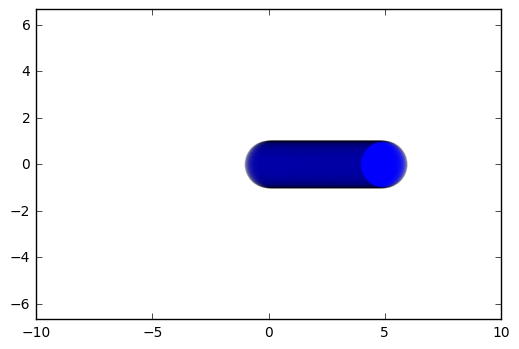

In [8]:
def drawTrajectory(Q: List[Configuration]) -> List[Circle]:
    patches = []
    radius = 1.0
    for q in Q:
        c = Circle((q.x, q.y), radius, facecolor="blue", edgecolor="blue", alpha=1.0)
        patches.append(c)
    return patches

def plotTrajectory(Q: List[Configuration]) -> None:
    figure = plt.figure()
    collection = PatchCollection(drawTrajectory(Q), alpha=0.3)
    ax = plt.gca()
    ax.add_collection(collection)
    plt.axis('equal')
    ax.set_ylim((-10, 10))
    ax.set_xlim((-10, 10))
    
plotTrajectory(Q)

# Paths

A *path* is a geometric curve in the workspace.  It is *not* a trajectory (a configuration as a function of time).  We will often consider piecewise-straight paths, also called *polyline* paths.  We will represent a polyline path as the line segments between a list of waypoints.  We will often represent a path $\sigma$ as a curve parameterized by arc length $s$, i.e. distance along the path.  Note that $s = 0$ at the start of the path, and $s = L$ at the end of the path, where $L$ is the length of the path.  Another way to write this is that $\sigma$ is really a function, $\sigma(s)$ that maps an arc length $s$ to a point $p \in \Workspace$:
$$
\begin{equation}
\sigma: [0, L] \rightarrow \Workspace \subset \R^2
\end{equation}
$$
In practice, we will call this function a *query* function, i.e. we will *query* the path at particular arc lengths $s$ to get the coordinates of the path at that arc length.


In [9]:
class Point:
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y = y

    def __repr__(self):
        fmtstr = "Point({:f}, {:f})"
        return fmtstr.format(self.x, self.y)

    
class LineSegment:
    def __init__(self, a: Point, b: Point) -> None:
        self.a = a
        self.b = b
        self.L = self.computeLength()
        
    def computeLength(self) -> float:
        return math.sqrt((self.b.x - self.a.x)**2 
                         + (self.b.y - self.a.y)**2)
        
    def query(self, s: float) -> Point:
        try:
            epsilon = 1e-5
            assert 0 <= s <= self.L + epsilon
        except AssertionError:
            print("self.L = {}, s = {}".format(self.L, s))
            raise
        s_frac = s / self.L
        x = (1.0 - s_frac) * self.a.x + s_frac * self.b.x
        y = (1.0 - s_frac) * self.a.y + s_frac * self.b.y
        return Point(x, y)
        

class PolylinePath:
    """
    A polyline, i.e. piecewise straight line, path.
    """
    
    def __init__(self, wps: List[Point]) -> None:
        # A LIST OF WAYPOINTS IS THE MAIN ATTRIBUTE
        self.wps = wps
        
        # THESE ARE HELPER ATTRIBUTES USED IN CLASS METHODS
        self.segments = self.computeSegments()
        self.cumulativeLength = self.computeCumulativeLength()
        self.L = self.computeLength()
        
    def computeLength(self) -> float:
        L = sum((seg.L for seg in self.segments))
        return L
    
    def computeSegments(self) -> List[LineSegment]:
        segments = []
        for a, b in zip(self.wps[0:-1], self.wps[1:]):
            segment = LineSegment(a, b)
            segments.append(segment)
        return segments
    
    def computeCumulativeLength(self) -> List[float]:
        cumulativeL = [0.0] + list(itertools.accumulate((seg.L for seg in self.segments)))
        return cumulativeL
    
    def query(self, s: float) -> Point:
        from bisect import bisect_left
        assert 0 <= s <= self.L
        # SEARCH FOR WHICH SEGMENT s LIES ON
        ind = bisect_left(self.cumulativeLength, s)
        # BECAUSE WE ZERO-PADDED THE cumulativeLength, WE REALLY NEED ind - 1
        ind = max(0, ind - 1)
        # print("ind = {}".format(ind))
        # GET THE SEGMENT RELATIVE QUERY POSITION
        s_rel =  s - self.cumulativeLength[ind]
        # print("s_rel = {}".format(s_rel))
        # QUERY THE SEGMENT TO GET THE Point
        point = self.segments[ind].query(s_rel)
        return point
    
    def samplePath(self, sList: List[float]) -> List[Point]:
        samples = []
        for s in sList:
            point = self.query(s)
            samples.append(point)
        return samples

Now let's make some random paths and draw them.

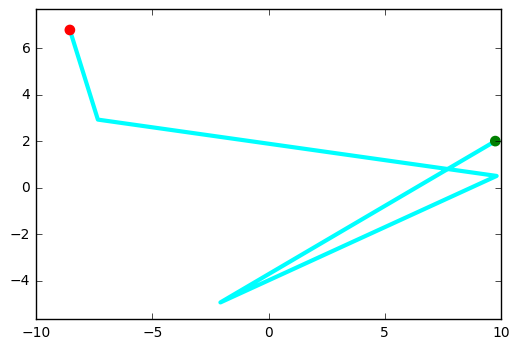

In [10]:
def getRandomWaypoints(N: int, boundary: List[Point]) -> List[Point]:
    wps = []
    x_min = min((p.x for p in boundary))
    x_max = max((p.x for p in boundary))
    y_min = min((p.y for p in boundary))
    y_max = max((p.y for p in boundary))
    for i in range(N):
        wp_x = random.uniform(x_min, x_max)
        wp_y = random.uniform(y_min, y_max)
        wps.append(Point(wp_x, wp_y))
    return wps

def drawPoint(p: Point, color: str):
    radius = 0.2
    circle = Circle((p.x, p.y), radius, facecolor=color, edgecolor=color, alpha=1.0, zorder=2)
    return circle

def drawPath(path: PolylinePath, color: str) -> Line2D:
    xdata = [p.x for p in path.wps]
    ydata = [p.y for p in path.wps]
    line = Line2D(xdata, ydata, color=color, linewidth=3, zorder=1)
    return line

def plotPath(path: PolylinePath):
    figure = plt.figure
    ax = plt.gca()
    ax.add_line(drawPath(path, "cyan"))
    start = path.wps[0]
    end = path.wps[-1]
    ax.add_patch(drawPoint(start, "green"))
    ax.add_patch(drawPoint(end, "red"))
    plt.axis('equal')

boundary = [Point(-10, -10),
            Point(-10, 10),
            Point(10, 10),
            Point(10, -10)]
wps = getRandomWaypoints(5, boundary)
path = PolylinePath(wps)
plotPath(path)

# Path tracking control

We will define a simple path tracking controller.  Here is some rough pseudocode.

```
def pathTrackingPolicy(t, q, s_attract, policy):
    s_attract = 0
    if distance(q, s_att) < D:
        s_attract += s_step
        # create control policy that minimizes distance to point of attraction
        policy = getPolicy(s_attract)
    return s_attract, policy
```

We will start by developing a control policy designed to move in a direction that minimizes the distance between the robot and a point of attraction.

In [11]:
class PathTrackingPolicy:
    """
    This is a nested control policy where the outer loop 
    picks points of attraction, and the inner loop is a feedback
    policy that moves in the direction of the point of attraction.
    """
    def __init__(self, path: PolylinePath) -> None:
        self.path = path
        self.s_attract = 0.1     # type: float
        self.param = {"D": 0.5, "s_step": 1.0}  # type Dict[str, float]
        self.p_attract = self.path.query(self.s_attract)
        self.innerPolicy = self.buildInnerPolicy(self.p_attract)
        
    def step(self, t: float, q: Configuration) -> Input:
        self.innerPolicy = self.stepOuter(t, q, self.innerPolicy)
        u = self.innerPolicy(q)
        return u
    
    def stepOuter(self, 
                  t,      # type: float, 
                  q,      # type: Configuration, 
                  policy  # type: Callable[[Configuration[, Input]
                 ) -> Callable[[Configuration], Input]:
        if self.distance(q, self.p_attract) < self.param["D"]:
            self.s_attract = min(self.path.L, self.s_attract + self.param["s_step"])
            self.p_attract = self.path.query(self.s_attract)
            policy = self.buildInnerPolicy(self.p_attract)
        return policy

    def buildInnerPolicy(self, p: Point) -> Callable[[Configuration], Input]:
        def policy(q: Configuration) -> Input:
            # COMPUTE UNIT VECTOR FROM q TO p
            speed = 1.0
            vector = (p.x - q.x, p.y - q.y)
            mag = math.sqrt(vector[0]**2 + vector[1]**2)
            unit_vector = (vector[0]/mag, vector[1]/mag)
            return Input(speed * unit_vector[0],
                         speed * unit_vector[1])
        return policy
    
    def distance(self, q: Configuration, p: Point) -> float:
        return math.sqrt((q.x - p.x)**2 
                         + (q.y - p.y)**2)

In [12]:
def simulate(f,         # type: Callable[[float, Configuration, Input], Velocity]
             policy,    # type: PathTrackingPolicy
             q0,        # type: Configuration,
             t_sample   # type: List[float]
            ) -> List[Configuration]:
    Q = [q0]  # type: List[Configuration]
    integration_intervals = zip(t_sample[0:-1], t_sample[1:])
    for t0, t1 in integration_intervals:
        u = policy.step(t0, Q[-1])
        q_next = eulerIntegrate(f, u, Q[-1], t0, t1)
        Q.append(q_next)
    return Q

In [13]:
policy = PathTrackingPolicy(path)

N = 100
sample_period = 0.1
t_sample = list(itertools.accumulate([sample_period] * N))
q0 = Configuration(0.0, 0.0)
Q = simulate(f, policy, q0, t_sample)

# plotTrajectory(Q)

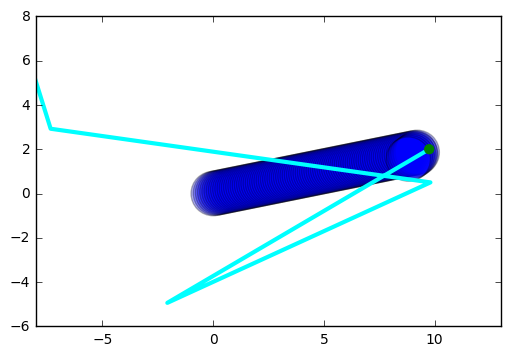

In [14]:
def plotPathAndTrajectory(path: PolylinePath, Q: List[Configuration]):
    figure = plt.figure
    ax = plt.gca()
    ax.add_line(drawPath(path, "cyan"))
    start = path.wps[0]
    end = path.wps[-1]
    ax.add_patch(drawPoint(start, "green"))
    ax.add_patch(drawPoint(end, "red"))
    collection = PatchCollection(drawTrajectory(Q), alpha=0.3)
    ax = plt.gca()
    ax.add_collection(collection)
    plt.axis('equal')
    
plotPathAndTrajectory(path, Q)

In [15]:
def simulate(f,         # type: Callable[[float, Configuration, Input], Velocity]
             policy,    # type: PathTrackingPolicy
             q0,        # type: Configuration,
             t0,        # type: float
             period,    # type: float
             stopCondition # type: Callable[[Configuration], bool]
            ) -> List[Configuration]:
    Q = [q0]  # type: List[Configuration]
    t = t0
    while not stopCondition(Q[-1]):
        u = policy.step(t0, Q[-1])
        q_next = eulerIntegrate(f, u, Q[-1], t, t + period)
        Q.append(q_next)
        t += period
    return Q

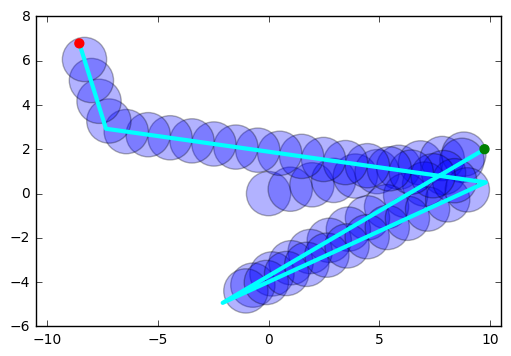

In [16]:
def distance(q: Configuration, p: Point) -> float:
    return math.sqrt((q.x - p.x)**2 
                     + (q.y - p.y)**2)

def stopCondition(q: Configuration) -> bool:
    end = path.query(path.L)
    if distance(q, end) < 0.1:
        return True
    else:
        return False
    
t0 = 0.0
period = 0.1
policy = PathTrackingPolicy(path)
q0 = Configuration(0.0, 0.0)
Q = simulate(f, policy, q0, t0, period, stopCondition)
plotPathAndTrajectory(path, Q[::10])